In [1]:
library(igraph)
library(ggnetwork)
library(tidygraph)
library(tidyverse)
library(cowplot)
library(ggrepel)
library(scatterpie)

results <- '../results/'
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    left_join(vegas, by = c('name' = 'Gene'))
class(ppi) <- c('igraph','tbl_graph')

method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff7f00', 'SConES GI' = '#cb181d',
                    'SigMod' = '#377eb8')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2


Attaching package: ‘tidygraph’


The following object is masked from ‘package:igraph’:

    groups


The following object is masked from ‘package:stats’:

    filter


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ dplyr::groups()        masks tidygraph::groups(), igraph::groups()
✖ dplyr::

In [2]:
genes <- list.files('../results/benchmark/all_outputs') %>%
    lapply(function(x) {
        read_tsv(paste0('../results/benchmark/all_outputs/', x), col_names = F, col_types = 'c') %>%
            rename(gene = X1) %>%
            filter(gene != 'gene') %>%
            unique %>%
            mutate(method = gsub('_[0-9]*.txt', '', x = x),
                   id = gsub('.*_', '', x = x),
                   id = gsub('.txt', '', x = id))
    }) %>%
    bind_rows %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'consensus', 'Consensus', method))

genes_wide <- group_by(genes, gene, method) %>% 
    summarize(n = n()) %>% spread(key = method, value = n) %>%
    mutate(Consensus = ifelse(is.na(Consensus), 0, Consensus),
           dmGWAS = ifelse(is.na(dmGWAS), 0, dmGWAS),
           heinz = ifelse(is.na(heinz), 0, heinz),
           HotNet2 = ifelse(is.na(HotNet2), 0, HotNet2),
           `SConES GI` = ifelse(is.na(`SConES GI`), 0, `SConES GI`),
           SigMod = ifelse(is.na(SigMod), 0, SigMod),
           n = rowSums(cbind(dmGWAS, heinz, HotNet2, `SConES GI`, SigMod)))

# Read known genes
bcac_genes <- read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                       col_types = 'iciddddddcd') %>%
    filter(`Top-0.1-pvalue` < 0.05 / n()) %>%
    .$Gene

known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene

# Consensus of consensuses

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


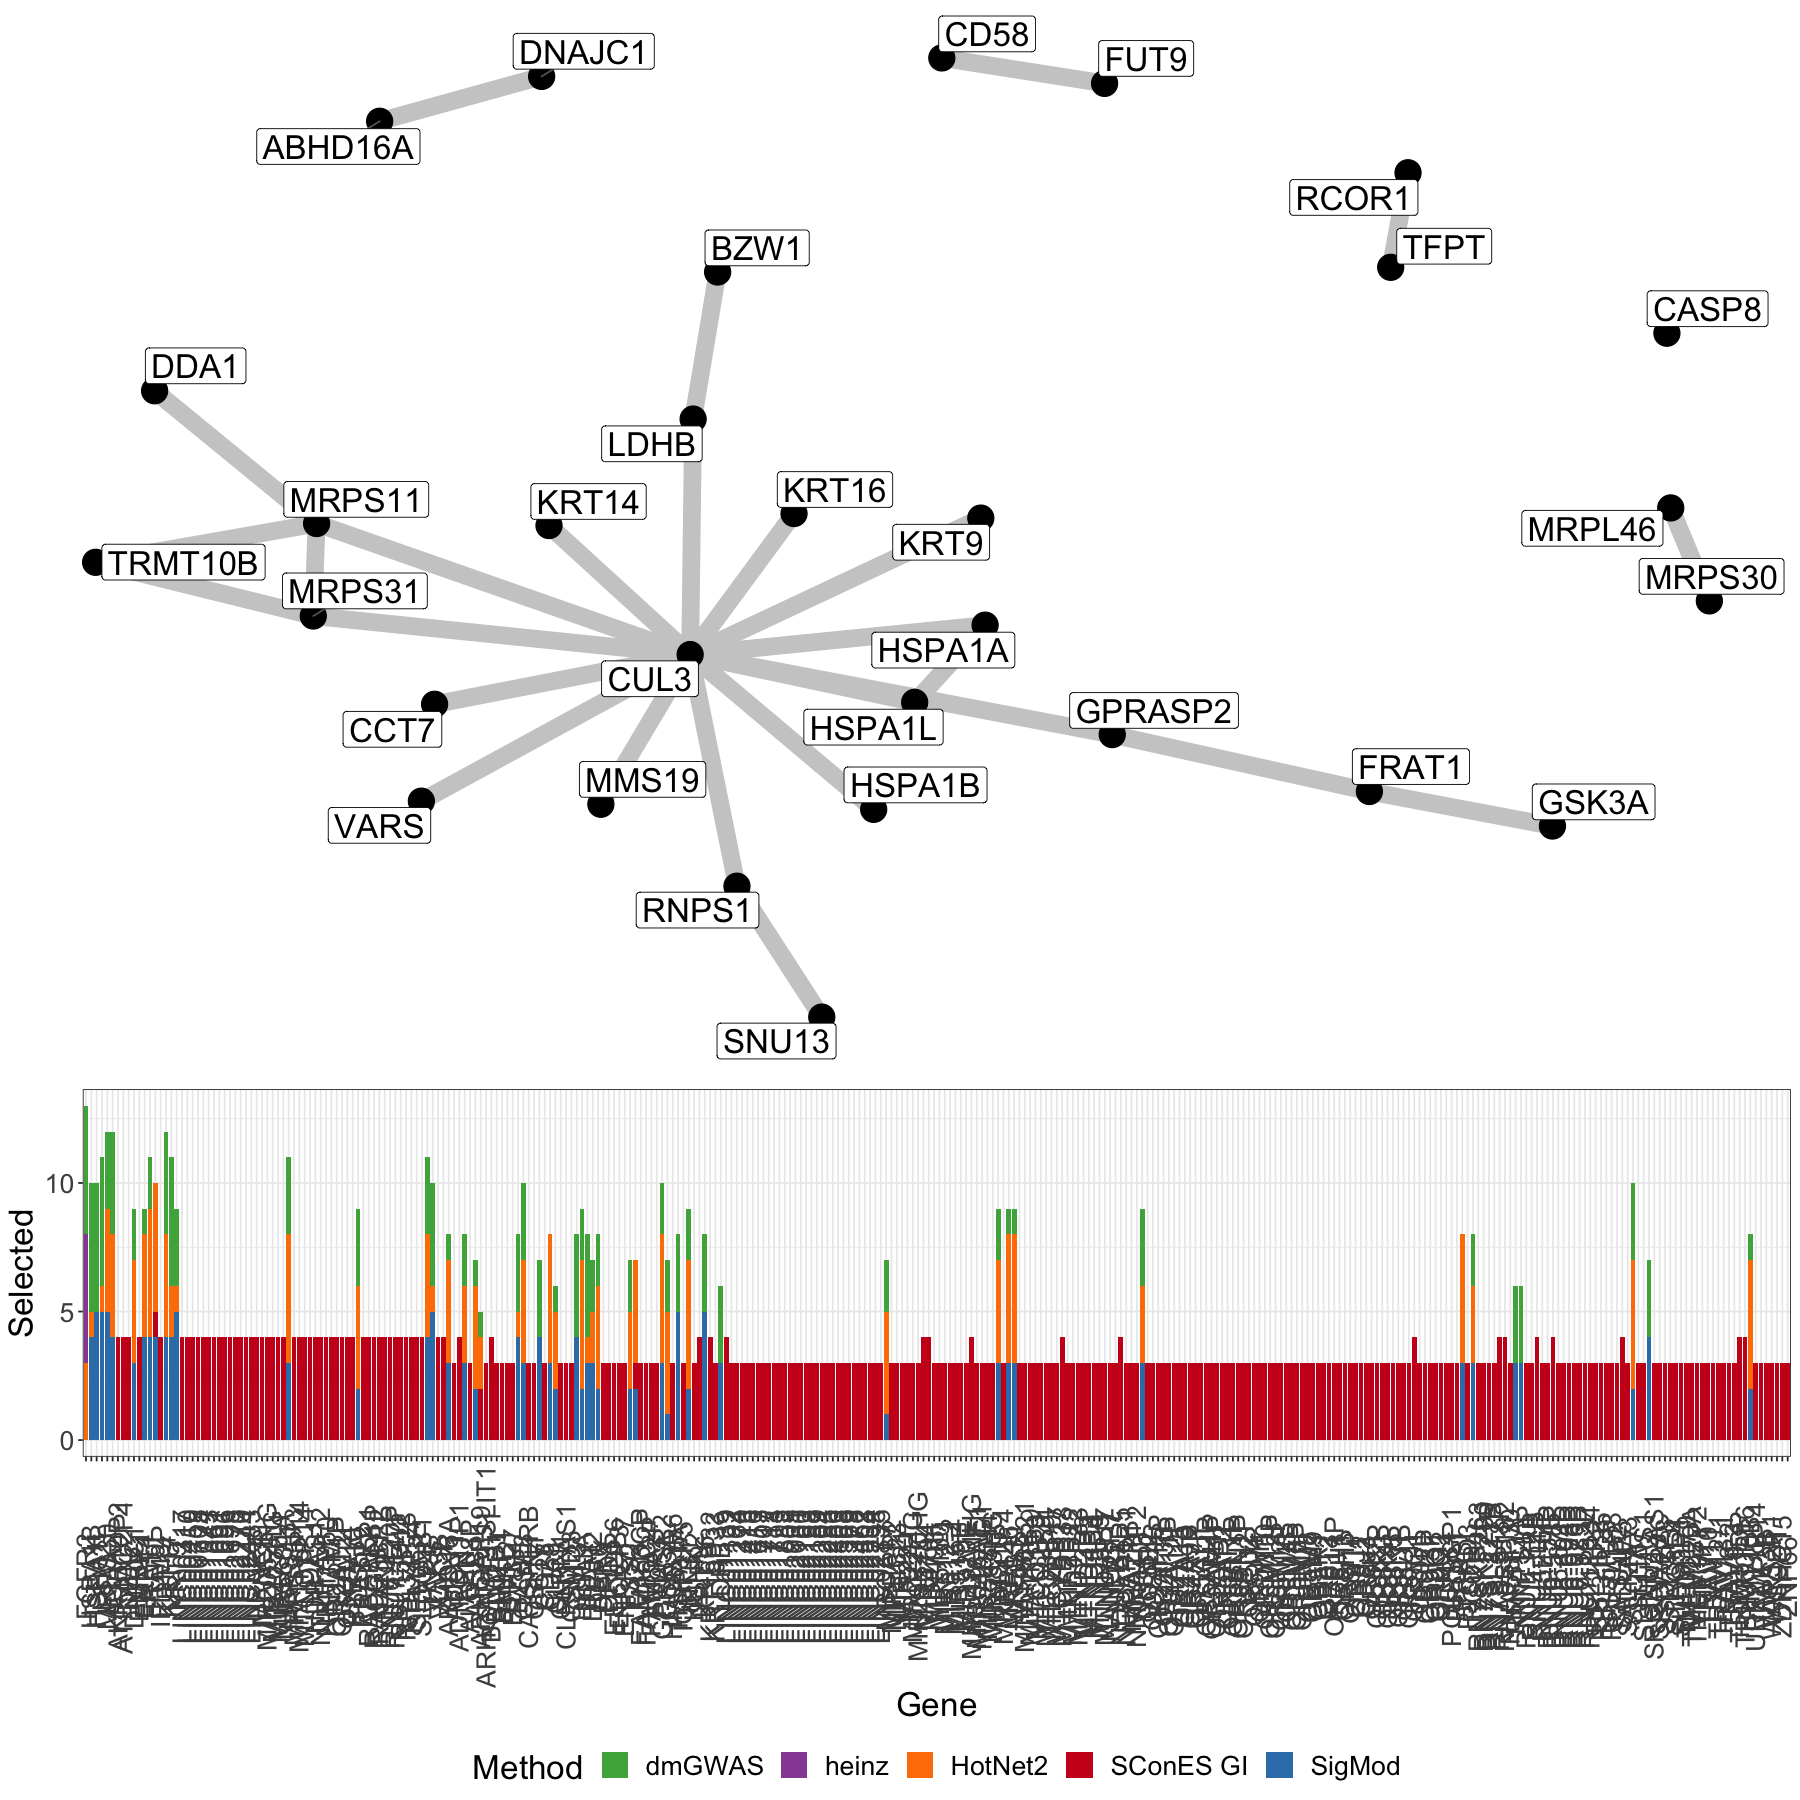

In [3]:
consensus_2 <-  genes %>%
    filter(method == 'Consensus') %>%
    group_by(gene) %>%
    summarize(n = n()) %>%
    filter(n > 2) %>%
    arrange(-n) %>%
    .$gene

net <- ppi %>%
    filter(name %in% consensus_2) %>%
    filter(!node_is_isolated()) %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(size = 5, color = 'grey80') +
        geom_nodes(size = 7) +
        geom_nodelabel_repel(aes(label = name), size = 7) +
        theme_blank() +
        theme(text = element_text(size = 18))

hist <- filter(genes, gene %in% consensus_2 & method != 'Consensus') %>%
    mutate(gene = factor(gene, levels = consensus_2)) %>%
    ggplot(aes(x = gene, fill = method)) +
        geom_histogram(stat="count") +
        labs(x = 'Gene', y = 'Selected', fill = 'Method') +
        theme_bw() +
        scale_fill_manual(values = method_palette) +
        theme(legend.position = 'bottom',
              text = element_text(size = 20),
              axis.text.x = element_text(angle = 90, vjust = 0.5))

options(repr.plot.width=15, repr.plot.height=15)
plot_grid(net, hist, rel_heights = c(1.5,1), nrow = 2)

# Consensus of methods

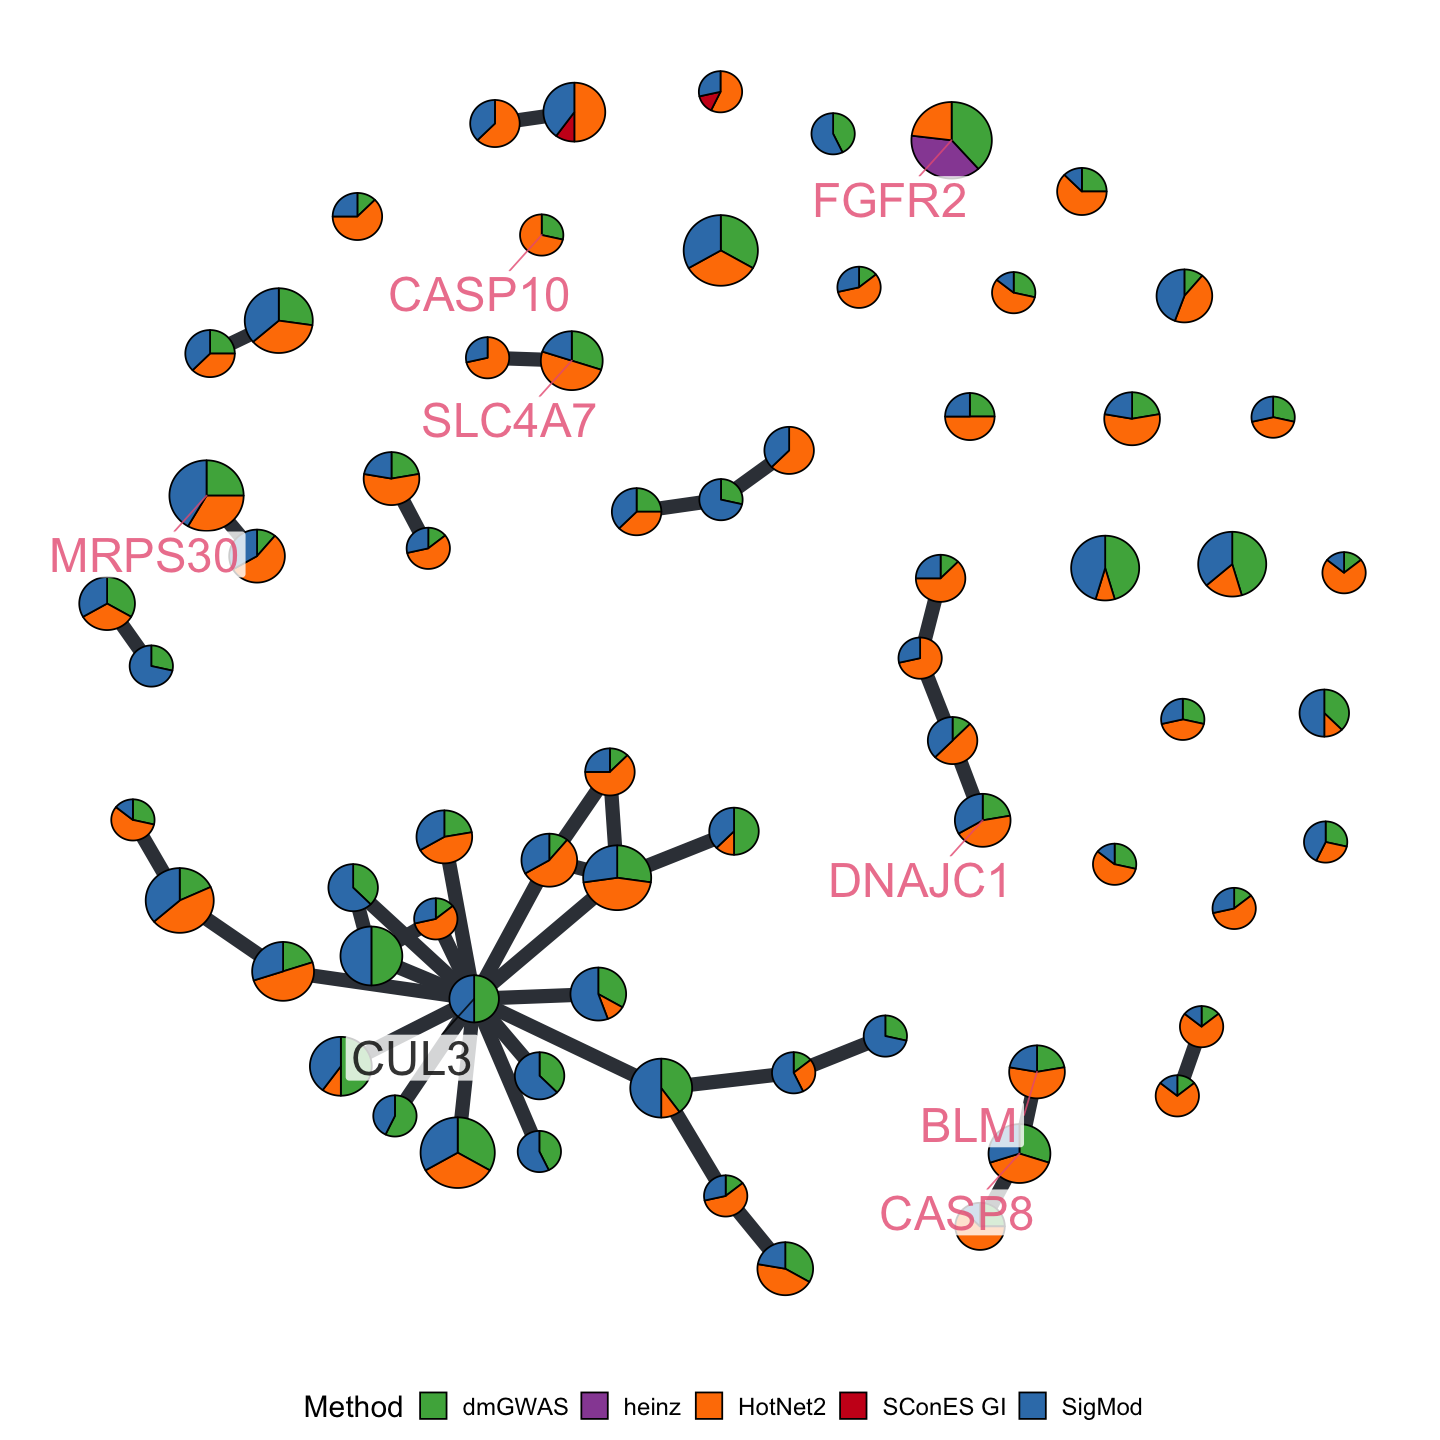

In [4]:
consensus_methods <- genes %>%
    filter(method != 'Consensus') %>%
    group_by(gene) %>%
    summarize(n = n()) %>%
    filter(n > 6) %>%
    arrange(-n) %>%
    .$gene

net <- ppi %>%
    filter(name %in% consensus_methods) %>%
    inner_join(genes_wide, by = c('name' = 'gene')) %>%
    mutate(known = name %in% bcac_genes | name %in% known_brca_genes,
           degree = centrality_degree()) %>%
    ggnetwork

options(repr.plot.width=12, repr.plot.height=12)
ggplot(net, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(size = 4, color = '#393e46') +
        geom_scatterpie(data = filter(net, x == xend & y == yend), 
                        aes(x = x, y = y, r = n/400), cols = names(method_palette)) +
        geom_label_repel(data = filter(net, x == xend & y == yend & (known | degree > 4)), 
                         aes(x = x, y = y, label = name, color = known), 
                         nudge_x = -.05, nudge_y = -.05, alpha = .8, label.size = NA,
                         hjust = 0.5, vjust = 0.5, size = 10) + 
        labs(fill = 'Method') +
        scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
        scale_fill_manual(values = method_palette) +
        guides(color = FALSE) +
        theme_blank() +
        theme(legend.position = 'bottom',
              text = element_text(size = 18))

tibble(gene = consensus_methods) %>%
    write_tsv(paste0(results,'benchmark/selected_genes.stability.txt'))

In [5]:
# percentile of the current threshold (6)
(genes %>%
    filter(method != 'Consensus') %>%
    group_by(gene) %>%
    summarize(n = n()) %>%
    .$n %>%
    ecdf)(6)

[1] 0.9891043

In [6]:
# size
length(consensus_methods)

[1] 68

In [7]:
as_tbl_graph(ppi) %>%
    filter(name %in% consensus_methods) %>%
    filter(node_is_isolated())

# A tbl_graph: 19 nodes and 0 edges
#
# An undirected simple graph with 19 components
#
# Node Data: 19 x 2 (active)
  name           p
  <chr>      <dbl>
1 DDAH2 0.00264   
2 FGFR2 0.00000100
3 SNU13 0.0250    
4 UCP2  0.00155   
5 KRT17 0.00311   
6 FHL5  0.00656   
# … with 13 more rows
#
# Edge Data: 0 x 2
# … with 2 variables: from <int>, to <int>

## Gene set enrichment analysis

In [8]:
suppressPackageStartupMessages(library(ReactomePA))
dict <- read_tsv('../results/preprocessing/non_alt_loci_set.txt',
                          col_types = cols(.default = "c")) %>%
    select(symbol, entrez_id)

symbol2entrez <- dict$entrez_id
names(symbol2entrez) <- dict$symbol

entrez2symbol <- dict$symbol
names(entrez2symbol) <- dict$entrez_id

universe <- read_tsv('~/data/genesis/genesis_2019.bim', col_names = F, col_types = 'iciicc') %>%
    inner_join(read_tsv('../results/preprocessing/snp2hgnc.tsv', col_types = 'cc'), 
               by = c('X2' = 'snp')) %>%
    .$gene %>%
    symbol2entrez[.] %>%
    unique

In [9]:
enrichPathway(gene = symbol2entrez[consensus_methods],
              universe = universe) %>%
    as_tibble %>%
    rowwise %>%
    mutate(geneID = strsplit(geneID, '/'),
           geneID = entrez2symbol[unlist(geneID)] %>% paste(collapse = '/'))

Loading required package: org.Hs.eg.db

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
 

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-3371568,Attenuation phase,3/51,13/9954,0.0000349552,0.00887862,0.008646812,HSPA1B/HSPA1L/HSPA1A,3
R-HSA-3371571,HSF1-dependent transactivation,3/51,23/9954,0.0002087669,0.02651340,0.025821168,HSPA1B/HSPA1L/HSPA1A,3
R-HSA-5368286,Mitochondrial translation initiation,4/51,84/9954,0.0008720976,0.04430256,0.043145883,MRPS30/MRPS11/MRPL46/MRPS31,4
R-HSA-5389840,Mitochondrial translation elongation,4/51,84/9954,0.0008720976,0.04430256,0.043145883,MRPS30/MRPS11/MRPL46/MRPS31,4
R-HSA-5419276,Mitochondrial translation termination,4/51,84/9954,0.0008720976,0.04430256,0.043145883,MRPS30/MRPS11/MRPL46/MRPS31,4
R-HSA-5368287,Mitochondrial translation,4/51,90/9954,0.0011291317,0.04779991,0.046551920,MRPS30/MRPS11/MRPL46/MRPS31,4
